In [59]:
import os
import pandas as pd
import numpy as np
import pickle

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from gensim.utils import simple_preprocess

import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None) 


df = pd.read_pickle('data/allocine_dataset.pickle')
df_train = df['train_set']
df_val = df['val_set']
df_test = df['test_set']
df_test.head(1)

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-25385/critiques/spectateurs,"Magnifique épopée, une belle histoire, touchante avec des acteurs qui interprètent très bien leur rôles (Mel Gibson, Heath Ledger, Jason Isaacs...), le genre de film qui se savoure en famille! :)",1


## I. Word2Vec

Il existe deux variantes du Word2vec, les deux utilisent un réseau de neurones à 3 couches (1 couche d’entrée, 1 couche cachée, 1 couche de sortie) : Common Bag Of Words (CBOW) et Skip-gram.

On s'intéresse ici à CBOW : Le modèle est nourri par le contexte, et prédit le mot cible.

Tout d'abord, après avoir preprocessé le texte (lowercases & tokenizes), il nous faut entraîner le tokenizer sur le train set.

In [60]:
# Tokenize the text column to get the new column 'tokenized_text'
df_train['tk_review'] = df_train['review'].apply(lambda x : simple_preprocess(x)) 
df_val['tk_review'] = df_val['review'].apply(lambda x : simple_preprocess(x)) 
df_test['tk_review'] = df_test['review'].apply(lambda x : simple_preprocess(x)) 

Maintenant que le texte est nettoyé, nous pouvons procéder à l'encodage de celui-ci. Pour faire cela, nous utilisons la classe Tokenizer de Keras. 

In [17]:
# tweak this params to get better results for a given dataset
MAX_CORPUS_SIZE = 50000

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_CORPUS_SIZE, oov_token="<unk>")
tokenizer.fit_on_texts(df_train['review'])

print(f"Unique tokens: {len(tokenizer.word_index)}")

2022-05-30 14:57:40.758596: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-30 14:57:40.758611: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Found 186308 unique tokens.


In [56]:
# saving tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
train_reviews_tokenized = tokenizer.texts_to_sequences(df_train['review'])
val_reviews_tokenized = tokenizer.texts_to_sequences(df_val['review'])
test_reviews_tokenized = tokenizer.texts_to_sequences(df_test['review'])

Il est important de réaliser le padding des différentes reviews afin d'avoir la même input size pour chacune d'entre elle. On calcule la longueur de chacune et on décide du threshold.

In [13]:
reviews_len = [len(s) for s in train_reviews_tokenized+val_reviews_tokenized+test_reviews_tokenized]
reviews_len = pd.Series(reviews_len)
reviews_len.describe(percentiles=[.25, .50, .75, 0.95, 0.99, 0.999])

count    200000.000000
mean         91.479345
std          75.830984
min           0.000000
25%          33.000000
50%          66.000000
75%         130.000000
95%         255.000000
99%         321.000000
99.9%       347.000000
max         389.000000
dtype: float64

99.9% des valeurs sont inférieur à 347. On retient donc comme longueur maximale d'une review 350.

In [19]:
MAX_LEN = 350

X_train = pad_sequences(train_reviews_tokenized, maxlen=MAX_LEN, padding='post')
X_val = pad_sequences(val_reviews_tokenized, maxlen=MAX_LEN, padding='post')
X_test = pad_sequences(test_reviews_tokenized, maxlen=MAX_LEN, padding='post')

y_train = np.array(df_train['polarity'])
y_val = np.array(df_val['polarity'])
y_test = np.array(df_test['polarity'])

Désormais, on construit l'architecture du modele Word2Vec grâce à Keras et aux modules : models et layers.

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

model = Sequential(name='Word2Vec')
model.add(Embedding(MAX_CORPUS_SIZE, 300, input_shape=[None]),)
model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation="sigmoid"))

2022-05-30 16:47:03.765798: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 16:47:03.766655: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-30 16:47:03.766737: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-05-30 16:47:03.766806: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-05-30 16:47:03.766893: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [53]:
# we can tweak this also, but usually adam gives good results
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [54]:
# save only best model
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath='data/cbow_weights.hdf5', save_best_only=True, verbose=1
)

# train model
history = model.fit(
    X_train, y_train, validation_data=(X_val, y_val),
    epochs=10, batch_size=128, callbacks=[checkpointer], verbose=1)

Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 0.4198 - accuracy: 0.8417
Epoch 00001: val_loss improved from inf to 0.25957, saving model to data/cbow_weights.hdf5
1250/1250 [==============================] - 162s 130ms/step - loss: 0.4198 - accuracy: 0.8417 - val_loss: 0.2596 - val_accuracy: 0.9119
Epoch 2/10
1250/1250 [==============================] - ETA: 0s - loss: 0.2211 - accuracy: 0.9224
Epoch 00002: val_loss improved from 0.25957 to 0.21075, saving model to data/cbow_weights.hdf5
1250/1250 [==============================] - 161s 129ms/step - loss: 0.2211 - accuracy: 0.9224 - val_loss: 0.2108 - val_accuracy: 0.9254
Epoch 3/10
1250/1250 [==============================] - ETA: 0s - loss: 0.1795 - accuracy: 0.9346
Epoch 00003: val_loss improved from 0.21075 to 0.20091, saving model to data/cbow_weights.hdf5
1250/1250 [==============================] - 185s 148ms/step - loss: 0.1795 - accuracy: 0.9346 - val_loss: 0.2009 - val_accuracy: 0.9291
Epoch 4/10
125

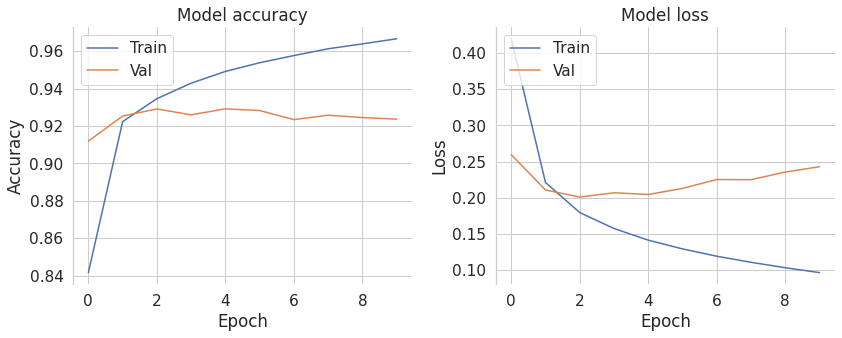

In [60]:
# plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# plot accuracies
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Val'], loc='upper left')

# plot losses
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Val'], loc='upper left')

sns.despine(bottom=True)
plt.tight_layout(h_pad=2)


In [65]:
model.load_weights('data/cbow_weights.hdf5')

probas = model.predict(X_test[1:])
y_pred = (probas > 0.5).astype(np.int)

/tmp/ipykernel_14511/1667429351.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = (probas > 0.5).astype(np.int)


In [61]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9313    0.9325    0.9319     10408
           1     0.9266    0.9254    0.9260      9592

    accuracy                         0.9291     20000
   macro avg     0.9290    0.9289    0.9289     20000
weighted avg     0.9290    0.9291    0.9290     20000



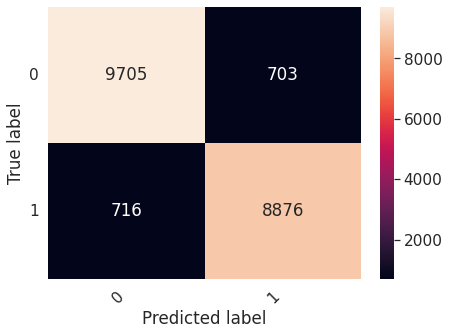

In [58]:
conf_mx = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(conf_mx)
fig = plt.figure(figsize=(7,5))

heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(
    heatmap.yaxis.get_ticklabels(), rotation=0,
    ha='right')
heatmap.xaxis.set_ticklabels(
    heatmap.xaxis.get_ticklabels(), rotation=45,
    ha='right')

plt.ylabel('True label')
plt.xlabel('Predicted label');

Ce premier modèle est déjà très intéressant en terme de métriques et l'on observe pas de déséquilibre particulier dans les prédictions. 

## II. FastText


FastText est capable d'obtenir de très bonnes performances pour la représentation des mots et la classification des phrases, en particulier dans le cas de mots rares, en utilisant les informations au niveau des caractères.

In [5]:
# import fasttext.util

# pre-trained word vectors (here we will train fasttext from scratch instead)
# fasttext.util.download_model('fr', if_exists='ignore')  # French
# ft = fasttext.load_model('cc.fr.300.bin')

fastText attend d'abord la catégorie, avec le préfixe '__label__' avant chaque catégorie, puis le texte d'entrée prétraité. Les étapes suivantes se passent sous le capot.

In [39]:
train = pd.concat([df_train['polarity'], df_train['tk_review']], axis=1)
val = pd.concat([df_val['polarity'], df_val['tk_review']], axis=1)
test = pd.concat([df_test['polarity'], df_test['tk_review']], axis=1)
test.head()

,polarity,tk_review
0,1,"[magnifique, épopée, une, belle, histoire, touchante, avec, des, acteurs, qui, interprètent, très, bien, leur, rôles, mel, gibson, heath, ledger, jason, isaacs, le, genre, de, film, qui, se, savoure, en, famille]"
1,0,"[je, ai, pas, aimé, mais, pourtant, je, lui, mets, étoiles, car, expérience, est, louable, rien, de, conventionnel, ici, une, visite, mais, jonchée, idées, originales, le, soucis, tout, ceci, avait, il, vraiment, sa, place, dans, un, film, de, tirant, sur, horreur, voici, un, film, qui, inverse, de, tant, autres, qui, ont, droit, mériterait, peut, être, un, remake]"
2,1,"[un, dessin, animé, qui, brille, par, sa, féerie, et, ses, chansons]"
3,0,"[si, est, là, le, renouveau, du, cinéma, français, est, tout, de, même, foutrement, chiant, si, objet, est, très, stylisé, et, la, tension, palpable, le, film, paraît, plutôt, creux]"
4,0,"[et, pourtant, on, en, doutait, second, volet, très, mauvais, sans, fraîcheur, et, lourdingue, quel, dommage]"


In [40]:
# Prefixing each row of the category column with '__label__'
train.iloc[:, 0] = train.iloc[:, 0].apply(lambda x: '__label__' + str(x))
val.iloc[:, 0] = val.iloc[:, 0].apply(lambda x: '__label__' + str(x))
test.iloc[:, 0] = test.iloc[:, 0].apply(lambda x: '__label__' + str(x))
test.head()

,polarity,tk_review
0,__label__1,"[magnifique, épopée, une, belle, histoire, touchante, avec, des, acteurs, qui, interprètent, très, bien, leur, rôles, mel, gibson, heath, ledger, jason, isaacs, le, genre, de, film, qui, se, savoure, en, famille]"
1,__label__0,"[je, ai, pas, aimé, mais, pourtant, je, lui, mets, étoiles, car, expérience, est, louable, rien, de, conventionnel, ici, une, visite, mais, jonchée, idées, originales, le, soucis, tout, ceci, avait, il, vraiment, sa, place, dans, un, film, de, tirant, sur, horreur, voici, un, film, qui, inverse, de, tant, autres, qui, ont, droit, mériterait, peut, être, un, remake]"
2,__label__1,"[un, dessin, animé, qui, brille, par, sa, féerie, et, ses, chansons]"
3,__label__0,"[si, est, là, le, renouveau, du, cinéma, français, est, tout, de, même, foutrement, chiant, si, objet, est, très, stylisé, et, la, tension, palpable, le, film, paraît, plutôt, creux]"
4,__label__0,"[et, pourtant, on, en, doutait, second, volet, très, mauvais, sans, fraîcheur, et, lourdingue, quel, dommage]"


In [41]:
# Saving the CSV file as a txt file
train.to_csv('train.txt', index = False, sep = ' ', header = None)
val.to_csv('val.txt', index = False, sep = ' ', header = None)
test.to_csv('test.txt', index = False, sep = ' ', header = None)

Pour améliorer les performances de notre modèle, le paramètre wordNgrams est fixé à 2. En d'autres termes, le modèle est entraîné sur des bigrammes au lieu de ne considérer uniquement des mots individuels.

Différentes méthodes d'entraînement sont fournies par la librarie : 
- train_unsupervised : c'est de l'apprentissage non supervisé en ce sens que l'on ne fournit que le corpus de texte à l'algorithme. Il va ensuite utiliser des fenêtres contextuelles glissantes pour son entraînement.

- train_supervised : ici, on fournit clairement l'objectif de classification (0/1, positif/négatif), l'apprentissage de l'embedding est implicite et intervient lors de l'apprentissage de la tâche de classification.

In [42]:
import fasttext

hyper_params = {"lr": 0.01,
    "epoch": 20,
    "wordNgrams": 2,
    "dim": 300}     
        
# Train the model.
model = fasttext.train_supervised('train.txt', **hyper_params)
print("Model trained with the hyperparameter \n {}".format(hyper_params))

Read 14M words
Number of words:  177567
Number of labels: 2
Progress:  99.9% words/sec/thread:  568155 lr:  0.000011 avg.loss:  0.228901 ETA:   0h 0m 0s  2.4% words/sec/thread:  574692 lr:  0.009761 avg.loss:  0.694646 ETA:   0h 0m32s  5.4% words/sec/thread:  576741 lr:  0.009460 avg.loss:  0.690002 ETA:   0h 0m31s 11.7% words/sec/thread:  576828 lr:  0.008830 avg.loss:  0.582607 ETA:   0h 0m29s 16.2% words/sec/thread:  575909 lr:  0.008383 avg.loss:  0.512588 ETA:   0h 0m28s 17.7% words/sec/thread:  575677 lr:  0.008234 avg.loss:  0.495569 ETA:   0h 0m27s 19.2% words/sec/thread:  575489 lr:  0.008085 avg.loss:  0.479169 ETA:   0h 0m27s

Model trained with the hyperparameter 
 {'lr': 0.01, 'epoch': 20, 'wordNgrams': 2, 'dim': 300}


100.0% words/sec/thread:  567078 lr: -0.000000 avg.loss:  0.228829 ETA:   0h 0m 0s
Progress: 100.0% words/sec/thread:  567074 lr:  0.000000 avg.loss:  0.228829 ETA:   0h 0m 0s


In [44]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.4f}".format(1, p))
    print("R@{}\t{:.4f}".format(1, r))

print_results(*model.test('test.txt'))

N	20000
P@1	0.9348
R@1	0.9348


Fasttext est meilleur que Word2vec, pour ce dataset. On gagne 0.55 point d'accuracy.

In [75]:
model = fasttext.load_model("fasttext_model_quant.ftz")

In [77]:
pred = model.predict("Magnifique épopée, une belle histoire, touchante avec des acteurs qui interprètent très bien leur rôles (Mel Gibson, Heath Ledger, Jason Isaacs...), le genre de film qui se savoure en famille! :)", k=2)
pred

(('__label__0', '__label__1'), array([0.65522462, 0.34479532]))

Lorsque l'on souhaite sauvegarder un modèle, fastText peut le compresser afin d'obtenir un fichier modèle beaucoup plus petit en ne sacrifiant qu'un peu de performance. Cela permet notamment d'optimiser le modèle pour sa mise en production.



In [51]:
# with the previously trained `model` object, call :
model.quantize(input='train.txt', retrain=True)

# then display results and save the new model :
print_results(*model.test('test.txt'))
model.save_model("fasttext_model_quant.ftz")

N	20000
P@1	0.9342
R@1	0.9342
